In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../scripts")
from TrackReconstruction_functions import *

pd.options.mode.chained_assignment = None  # Disable the warning

pressure=1
# diffusion="0.0percent"
# diffusion="nodiff"
diffusion="0.05percent"
file_id = "1"
# diffusion = "next1t"

diff_name = f"_{diffusion}"
if diff_name == "_nodiff":
    diff_name=""

hits_true = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_{pressure}bar_EFilt_smear_{file_id}.h5", "MC/hits")
hits      = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_{pressure}bar_EFilt{diff_name}_smear_{file_id}.h5", "MC/hits")

# hits_true = pd.read_hdf(f"../data/ATPC_Bi/ATPC_Bi_ion_{pressure}bar_Efilt_smear_{file_id}_4.h5", "MC/hits")
# hits      = pd.read_hdf(f"../data/ATPC_Bi/ATPC_Bi_ion_{pressure}bar_Efilt_{diffusion}_smear_{file_id}_4.h5", "MC/hits")

# hits = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_{pressure}bar_{diffusion}_filtered.h5", "MC/hits")
# hits_true = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_{pressure}bar_nexus_filtered.h5", "MC/hits")
# hits_true["z"]= hits_true["z"]+3000

# hits_true = pd.read_hdf(f"../config/NextTonScale_Bi_ion.h5", "MC/hits")
# hits      = pd.read_hdf(f"../config/NextTonScale_Bi_ion_Efilt.h5", "MC/hits")
# hits_true["z"]= hits_true["z"]+1300

# hits_true = pd.read_hdf(f"../config/NextTon_0nubb.h5", "MC/hits")
# hits      = pd.read_hdf(f"../config/NextTon_0nubb_Efilt.h5", "MC/hits")
# hits_true["z"]= hits_true["z"]+1300


# hits = pd.read_hdf("../data/ATPC_0nubb/ATPC_0nubb_1bar_5.0percent_smear_3273_1.h5", "MC/hits")

display(hits)

event_list = hits.event_id.unique()

print(hits.event_id.unique())

,event_id,x,y,z,energy
0,244,-191.169281,2621.830811,1450.0,0.001307
1,244,-191.169281,2650.830811,1450.0,0.002461
2,244,-191.169281,2679.830811,1450.0,0.000333
3,244,-162.169281,2592.830811,1450.0,0.001589
4,244,-162.169281,2621.830811,1450.0,0.011638
...,...,...,...,...,...
68305,309,910.830750,1751.830688,4553.0,0.000851
68306,309,910.830750,1780.830688,4553.0,0.000691
68307,309,939.830750,1722.830688,4553.0,0.000346
68308,309,939.830750,1751.830688,4553.0,0.000691


[244 245 246 247 248 249 250 251 252 253 254 255 256 258 259 260 261 263
 264 265 266 267 268 269 271 272 273 274 275 277 278 279 280 281 282 283
 284 285 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302
 303 304 305 306 307 308 309]


In [44]:
# eid=9844
eid=event_list[1]

data = hits[hits.event_id ==eid]
data_true = hits_true[hits_true.event_id ==eid]
display(data_true)

print(data.energy.sum())
print(data_true.energy.sum())

,event_id,x,y,z,energy
786,245,1148.830688,1233.830688,280.0,0.080692
787,245,1153.830688,1233.830688,280.0,0.007058
788,245,1158.830688,1228.830688,280.0,0.008960
789,245,1158.830688,1233.830688,280.0,0.002353
790,245,1163.830688,1228.830688,280.0,0.000576
...,...,...,...,...,...
1684,245,1283.830688,1528.830688,1440.0,0.001877
1685,245,1283.830688,1533.830688,1440.0,0.007408
1686,245,1288.830688,1513.830688,1440.0,0.003404
1687,245,1288.830688,1518.830688,1440.0,0.004055


2.4625902
2.4625902


In [45]:
hits.describe()

,event_id,x,y,z,energy
count,68310.000000,68310.000000,68310.000000,68310.000000,68310.000000
mean,277.259040,37.243843,228.976257,3525.415527,0.002197
std,19.542508,1229.760864,1347.199219,1518.661133,0.003132
min,244.000000,-2540.169189,-2917.169189,174.000000,0.000328
25%,260.000000,-1032.169312,-916.169250,2175.000000,0.000643
50%,278.000000,127.830727,475.830719,3886.000000,0.001242
75%,295.000000,968.830750,1345.830688,4756.000000,0.002511
max,309.000000,2505.830811,2911.830811,6177.000000,0.086607


In [46]:

Diff_smear, energy_threshold, diff_scale_factor, radius_sf, group_sf, Tortuosity_dist, voxel_size, det_size  = InitializeParams(pressure, diffusion)
# voxel_sf=1.1
# energy_threshold=0
print("Diffussion smear is: ",        Diff_smear,            "mm/sqrt(cm)")
print("Energy threshold is: ",        1000*energy_threshold, "keV")
print("diffision scale factor is: ",  diff_scale_factor)
print("Radius scale factor is: ",     radius_sf)
print("Hit grouping factor is: ",     group_sf)
print("Tortuosity distance scale is:", Tortuosity_dist)
print("The voxel size is:",           voxel_size)
print("The det_size is", det_size)

# energy_threshold = 0.0004

mean_sigma = diff_scale_factor*Diff_smear*np.sqrt(0.1*data.z.mean())

# The expected diffusion is less than vox size so replace
if (mean_sigma < 1.5*voxel_size):
    mean_sigma = 1.5*voxel_size


if (diffusion == "next1t"):
    mean_sigma=6
elif (diffusion == "nodiff"):
    mean_sigma=10/np.sqrt(pressure)

print("Mean sigma", mean_sigma)

# Create the bins ---- 
xbw  = mean_sigma
xmin = -det_size - mean_sigma/2 
xmax = det_size  + mean_sigma/2

ybw  = mean_sigma
ymin = -det_size - mean_sigma/2 
ymax = det_size  + mean_sigma/2

# This shifts the z pos of the events so 0 is at anode
# can set this to zero
z_shift = det_size
# z_shift = 0

zbw=mean_sigma
zmin=-det_size + z_shift - mean_sigma/2 
zmax=det_size + z_shift + mean_sigma/2

# bins for x, y, z
xbins = np.arange(xmin, xmax+xbw, xbw)
ybins = np.arange(ymin, ymax+ybw, ybw)
zbins = np.arange(zmin, zmax+zbw, zbw)

# center bins for x, y, z
xbin_c = xbins[:-1] + xbw / 2
ybin_c = ybins[:-1] + ybw / 2
zbin_c = zbins[:-1] + zbw / 2


Diffussion smear is:  2.0 mm/sqrt(cm)
Energy threshold is:  0.3 keV
diffision scale factor is:  5
Radius scale factor is:  7
Hit grouping factor is:  3
Tortuosity distance scale is: 175.0
The voxel size is: 29
The det_size is 3091.169274839764
Mean sigma 100.43454170227051


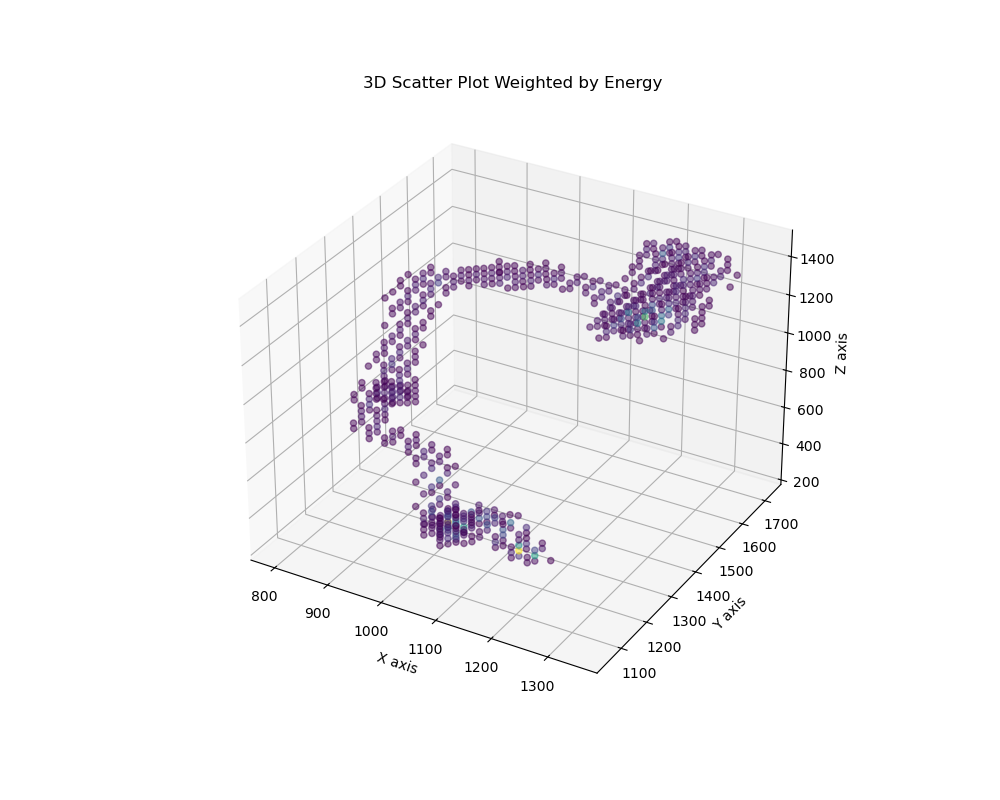

In [47]:
%matplotlib widget 

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Normalize the energy values for the colors
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(data.energy.min(), data.energy.max())
colors = cmap(norm(data.energy))


# Plot the scatter plot
scatter = ax.scatter(data.x, data.y, data.z, c=colors, marker='o', alpha=0.5)
# ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o', c="DarkOrange")

# ax.scatter(data_true['x'], data_true['y'], data_true['z']+3000, marker='o', c="DarkRed")

# Add color bar to indicate energy values
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array(data.energy)
# cbar = plt.colorbar(mappable)
# cbar.set_label('Energy')

# Set labels and title
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Scatter Plot Weighted by Energy')

plt.show()

In [48]:
print(data.energy.sum())

# If there are overlapping voxels, merge them. Otherwise the energy gets messed up
data = (data.groupby(["event_id", "x", "y", "z"], as_index=False)["energy"].sum())

# display(data)
data = data[['event_id','x', 'y', 'z',"energy"]]

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)

print(data.energy.sum())
display(data)

2.4625902
2.4625905


,event_id,x,y,z,energy
0,245,794.830750,1432.830688,1102.0,0.000430
1,245,794.830750,1461.830688,1102.0,0.000506
2,245,794.830750,1490.830688,1102.0,0.000506
3,245,794.830750,1490.830688,1131.0,0.000557
4,245,794.830750,1519.830688,1131.0,0.000456
...,...,...,...,...,...
622,245,1345.830688,1490.830688,1421.0,0.000531
623,245,1345.830688,1519.830688,1392.0,0.000633
624,245,1345.830688,1519.830688,1421.0,0.000531
625,245,1345.830688,1606.830688,1392.0,0.000557


Mean z: 1008.7097  diffusion =  100.43454170227051
Mean Sigma:  100.43454170227051


,x,y,z,energy,group_id
0,838.388245,1460.889526,1103.819702,0.070178,0
1,866.203247,1263.000854,792.633545,0.088526,0
2,869.852783,1527.678589,1155.206421,0.058638,0
3,890.870728,1279.422363,982.668274,0.097586,0
4,871.201111,1362.719482,1042.888794,0.019816,0
5,928.737183,1228.610962,683.732605,0.031888,0
6,907.706238,1260.734009,881.671753,0.040872,0
7,964.100952,1538.249390,1227.671753,0.048414,0
8,988.346985,1222.567627,647.144104,0.028092,0
9,1029.873047,1254.089111,335.146942,0.154630,0


27 2.4625904551066924


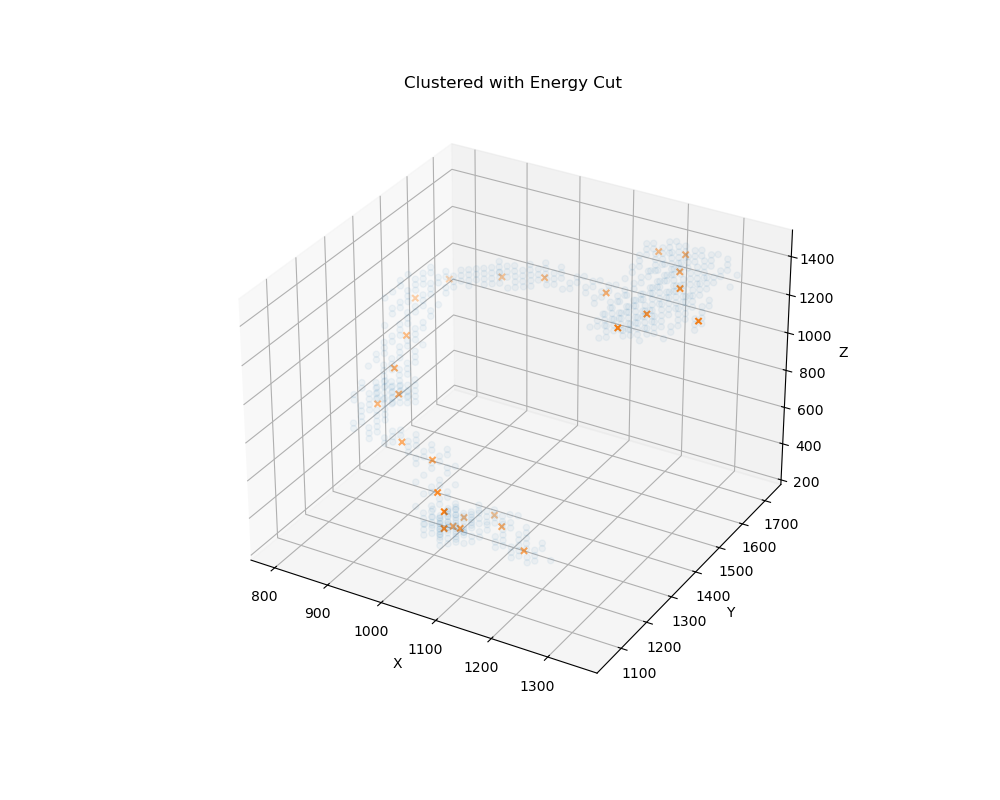

In [49]:

# display(data)

print("Mean z:", data.z.mean(), " diffusion = ", mean_sigma)
print("Mean Sigma: ", mean_sigma)


# Apply grouping
data_copy = data.copy()

df_merged = CutandRedistibuteEnergy(data_copy, energy_threshold)

mean_sigma_group = group_sf*Diff_smear*np.sqrt(0.1*data.z.mean())

if (mean_sigma_group < 1.5*voxel_size):
    mean_sigma_group = 1.5*voxel_size

if diffusion == "next1t":
    mean_sigma_group = 10
elif (diffusion == "nodiff"):
    mean_sigma_group=5

df_merged = GroupHits(df_merged, mean_sigma_group)

# Apply clustering
node_centers_df = []

for gid in sorted(df_merged.group_id.unique()):
    temp_df = df_merged[df_merged.group_id == gid]
    temp_df.reset_index(drop=True, inplace=True)
    node_centers_df.append(Cluster(temp_df, mean_sigma))

node_centers_df = pd.concat(node_centers_df, ignore_index=True)

display(node_centers_df)
print(len(node_centers_df), node_centers_df.energy.sum())

# -------

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Unclustered
# for gid in sorted(df_merged.group_id.unique()):
#     # ax.scatter(data['x'], data['y'], data['z'], marker='o',alpha=0.01)
#     # ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o')
#     temp_df = df_merged[df_merged.group_id == gid]
#     ax.scatter(temp_df['x'], temp_df['y'], temp_df['z'], marker='x')

# Clustered
for gid in sorted(node_centers_df.group_id.unique()):
    ax.scatter(df_merged['x'], df_merged['y'], df_merged['z'], marker='o',alpha=0.05)
    # ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o')
    temp_df = node_centers_df[node_centers_df.group_id == gid]
    ax.scatter(temp_df['x'], temp_df['y'], temp_df['z'], marker='x')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Clustered with Energy Cut')
plt.show()



In [50]:


databin = node_centers_df.copy()
databin["event_id"] = eid


# Now lets bin the data
databin['x_smear'] = pd.cut(x=databin['x'], bins=xbins,labels=xbin_c, include_lowest=True)
databin['y_smear'] = pd.cut(x=databin['y'], bins=ybins,labels=ybin_c, include_lowest=True)
databin['z_smear'] = pd.cut(x=databin['z'], bins=zbins,labels=zbin_c, include_lowest=True)

# Drop rows with any NaN values
databin = databin.dropna()

# Dictionary to store results
aggregated_data = {}

# Iterate through the DataFrame row by row
for _, row in databin.iterrows():
    key = (row['event_id'], row['x_smear'], row['y_smear'], row['z_smear'], row['group_id'])
    
    if key not in aggregated_data:
        # Initialize the aggregation for a new group
        aggregated_data[key] = {
            'x_sum': row['x'],
            'y_sum': row['y'],
            'z_sum': row['z'],
            'energy_sum': row['energy'],
            'group_id' : row['group_id'],
            'count': 1
        }
    else:
        # Update existing group values
        aggregated_data[key]['x_sum'] += row['x']
        aggregated_data[key]['y_sum'] += row['y']
        aggregated_data[key]['z_sum'] += row['z']
        aggregated_data[key]['energy_sum'] += row['energy']
        aggregated_data[key]['group_id'] = row['group_id']
        aggregated_data[key]['count'] += 1

# Convert aggregated data into a DataFrame
result = []
for key, values in aggregated_data.items():
    event_id, x_smear, y_smear, z_smear, group_id = key
    result.append({
        'event_id': event_id,
        'x_smear': x_smear,
        'y_smear': y_smear,
        'z_smear': z_smear,
        'x': values['x_sum'] / values['count'],   # Mean x
        'y': values['y_sum'] / values['count'],   # Mean y
        'z': values['z_sum'] / values['count'],   # Mean z
        'energy': values['energy_sum'],           # Sum energy
        'group_id' : int(group_id)
    })

# Create final DataFrame
databin = pd.DataFrame(result)

# then sort it based on the x,y,z
# databin = databin.sort_values(by=['x', "y", "z"]).reset_index(drop=True)


display(databin)


,event_id,x_smear,y_smear,z_smear,x,y,z,energy,group_id
0,245.0,825.777852,1428.385102,1104.779959,838.388245,1460.889526,1103.819702,0.070178,0
1,245.0,825.777852,1227.516018,803.476334,866.203247,1263.000854,792.633545,0.088526,0
2,245.0,825.777852,1528.819643,1205.214500,869.852783,1527.678589,1155.206421,0.058638,0
3,245.0,926.212393,1327.950560,1004.345417,890.870728,1279.422363,982.668274,0.097586,0
4,245.0,825.777852,1327.950560,1004.345417,871.201111,1362.719482,1042.888794,0.019816,0
5,245.0,926.212393,1227.516018,703.041792,928.737183,1228.610962,683.732605,0.031888,0
6,245.0,926.212393,1227.516018,903.910875,907.706238,1260.734009,881.671753,0.040872,0
7,245.0,926.212393,1528.819643,1205.214500,964.100952,1538.249390,1227.671753,0.048414,0
8,245.0,1026.646935,1227.516018,602.607250,988.346985,1222.567627,647.144104,0.028092,0
9,245.0,1026.646935,1227.516018,301.303625,1029.873047,1254.089111,335.146942,0.154630,0


/var/folders/cf/0fb79lcx5z9by5185swm__x00000gr/T/ipykernel_46343/3725678184.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10, 8))


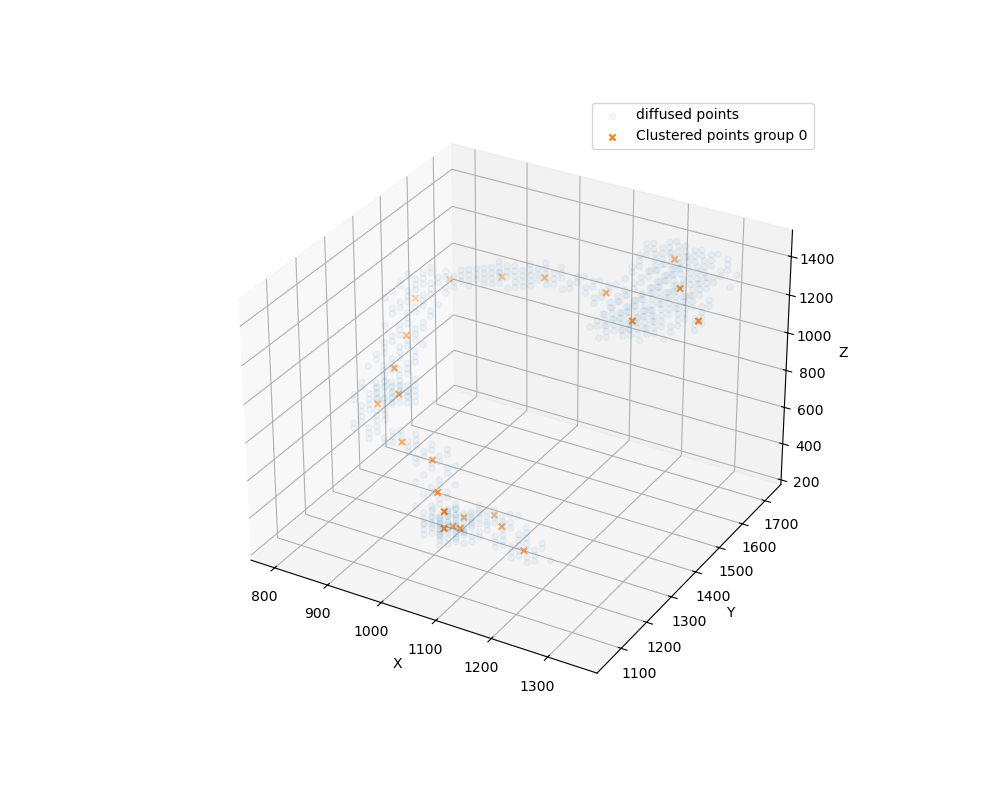

In [51]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(data['x'], data['y'], data['z'], marker='o',alpha=0.05, label = "diffused points")
# ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o',color="Teal")


for gid in sorted(databin.group_id.unique()):

    temp_df = databin[databin.group_id == gid]
    ax.scatter(temp_df['x'], temp_df['y'], temp_df['z'], marker='x', label = f"Clustered points group {gid}")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.legend()
plt.show()
plt.savefig("plots/clustering/clustered_hits1.pdf")

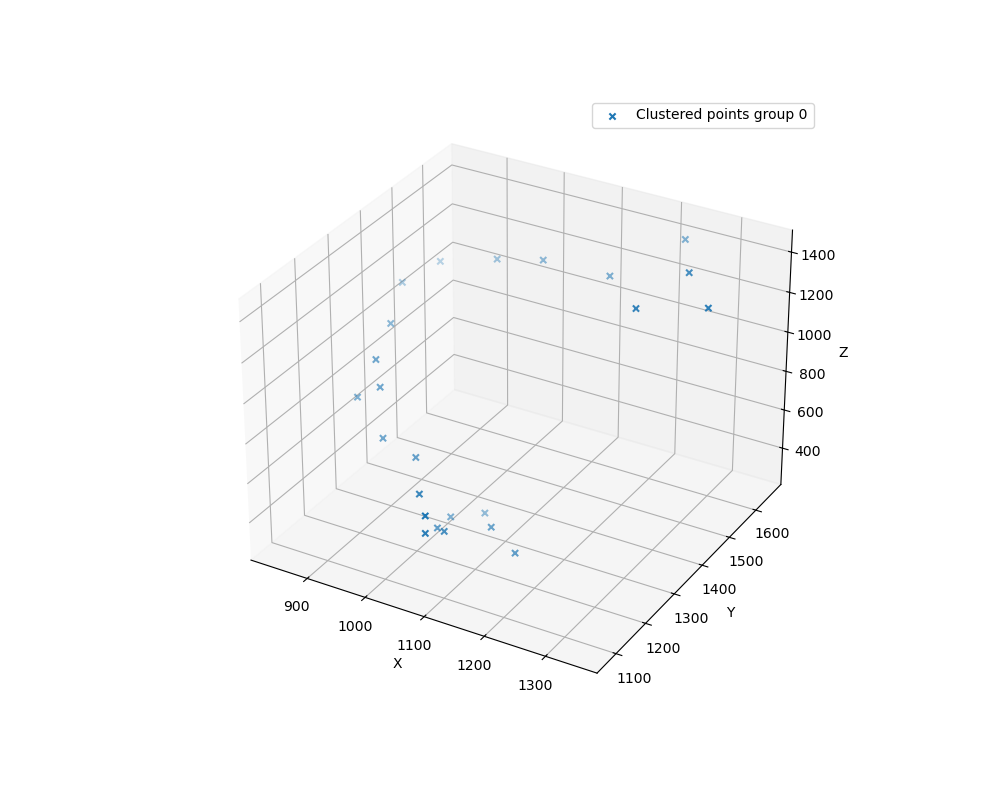

In [52]:

# Plot the original points and the polynomial fit
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for gid in sorted(databin.group_id.unique()):

    temp_df = databin[databin.group_id == gid]
    ax.scatter(temp_df['x'], temp_df['y'], temp_df['z'], marker='x', label = f"Clustered points group {gid}")

# ax.scatter(databin.x, databin.y,databin.z, color='blue', label='Clustered Points', alpha=0.5)
# ax.scatter(data_true['x'], data_true['y'], data_true['z'],s=0.1 ,marker='o',color="Teal")

# Labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()
plt.savefig("plots/clustering/clustered_hits2.pdf")

In [53]:
display(databin)

# databin.to_hdf("../data/test/test.h5", "MC/hits")

print(databin.energy.sum())

databin["group_id"]=0

,event_id,x_smear,y_smear,z_smear,x,y,z,energy,group_id
0,245.0,825.777852,1428.385102,1104.779959,838.388245,1460.889526,1103.819702,0.070178,0
1,245.0,825.777852,1227.516018,803.476334,866.203247,1263.000854,792.633545,0.088526,0
2,245.0,825.777852,1528.819643,1205.214500,869.852783,1527.678589,1155.206421,0.058638,0
3,245.0,926.212393,1327.950560,1004.345417,890.870728,1279.422363,982.668274,0.097586,0
4,245.0,825.777852,1327.950560,1004.345417,871.201111,1362.719482,1042.888794,0.019816,0
5,245.0,926.212393,1227.516018,703.041792,928.737183,1228.610962,683.732605,0.031888,0
6,245.0,926.212393,1227.516018,903.910875,907.706238,1260.734009,881.671753,0.040872,0
7,245.0,926.212393,1528.819643,1205.214500,964.100952,1538.249390,1227.671753,0.048414,0
8,245.0,1026.646935,1227.516018,602.607250,988.346985,1222.567627,647.144104,0.028092,0
9,245.0,1026.646935,1227.516018,301.303625,1029.873047,1254.089111,335.146942,0.154630,0


2.4625904551066924


Diffussion smear is:  2.0 mm/sqrt(cm)
Energy threshold is:  0.3 keV
diffision scale factor is:  5
Radius scale factor is:  7
Hit grouping factor is:  3
Tortuosity distance scale is: 175.0
The voxel size is: 29
The det half_length is:  3091.169274839764
Median distance to the closest row: 89.48956504226325
Distances to iterate over [  1  45  90 135 179 224 269 313 358 403 447 492 537 581 626]
Dist Thresh 416.248
Pass Flag: True
The primary track is:  0
    event_id            x            y            z  group_id    energy  id  \
0      245.0  1055.830688  1316.830688   290.000000         0  0.000430  13   
1      245.0  1152.023560  1230.295288   297.212860         0  0.187935  19   
2      245.0  1104.182007  1244.939087   364.605255         0  0.136307  17   
3      245.0  1029.873047  1254.089111   335.146942         0  0.154630   9   
4      245.0  1042.807861  1187.369141   385.465973         0  0.267528  12   
5      245.0  1075.141113  1149.015503   453.657593         0  0.02136

,event_id,x,y,z,group_id,energy,id,primary,trkID,cumulative_distance,angle,Tortuosity,Squiglicity
id,,,,,,,,,,,,,
13,245.0,1055.830688,1316.830688,290.000000,0,0.000430,13,1,0,0.000000,0.000000,1.000000,1.096604e-16
19,245.0,1152.023560,1230.295288,297.212860,0,0.187935,19,1,0,129.589619,96.745158,3.605420,1.868298e+00
17,245.0,1104.182007,1244.939087,364.605255,0,0.136307,17,1,0,213.524057,119.663692,1.695516,8.722939e-01
9,245.0,1029.873047,1254.089111,335.146942,0,0.154630,9,1,0,293.981106,75.386612,1.734535,1.071898e+00
12,245.0,1042.807861,1187.369141,385.465973,0,0.267528,12,1,0,378.543915,116.671307,1.862262,7.733427e-01
14,245.0,1075.141113,1149.015503,453.657593,0,0.021360,14,1,0,463.199321,26.465023,1.025046,1.507398e-01
15,245.0,1077.991821,1085.119995,538.397766,0,0.088754,15,1,0,569.367393,22.201361,1.504380,6.235646e-01
16,245.0,1081.685181,1079.153442,637.999939,0,0.009566,16,1,0,669.216446,33.576025,1.383456,6.257498e-01
11,245.0,1041.903687,1134.562500,632.456970,0,0.094803,11,1,0,737.652222,98.666220,1.354169,6.041315e-01


24 24


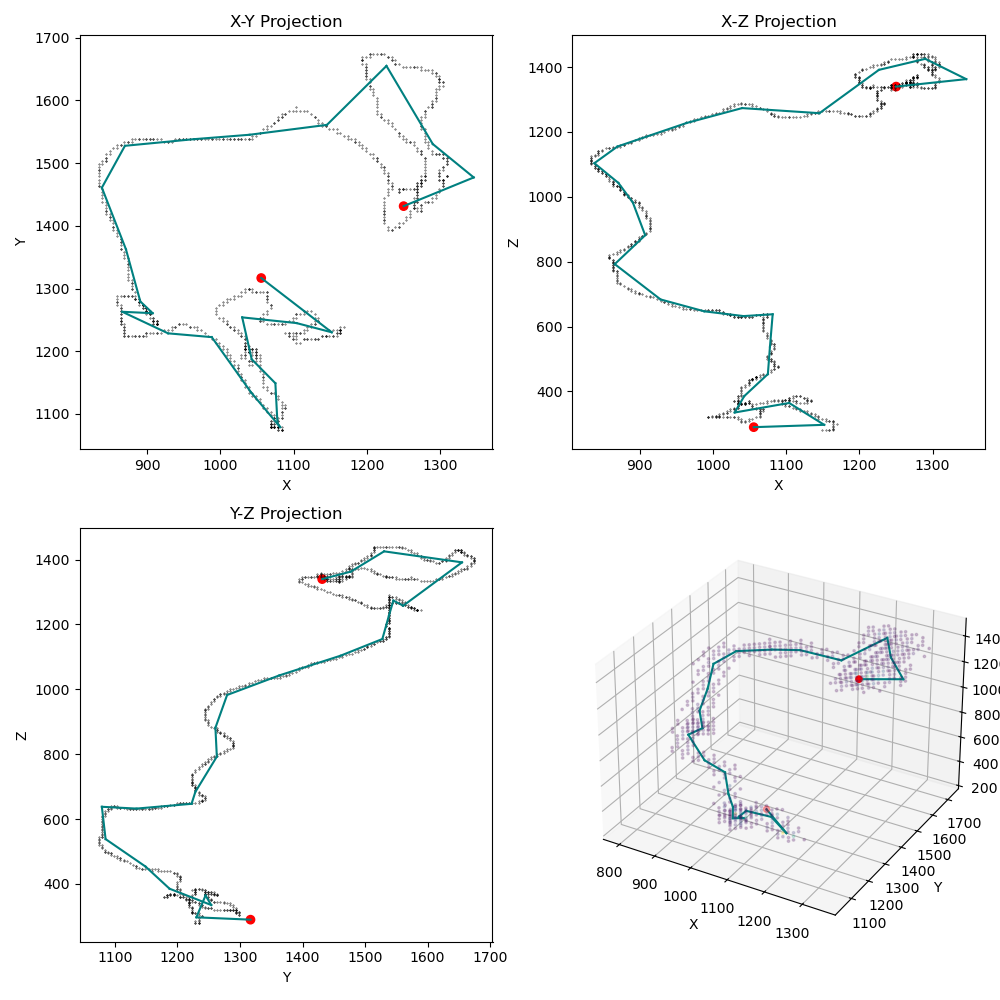

In [54]:
# Apply the tracking reconstruction

# df, Tracks, connected_nodes, connection_count, pass_flag = RunTracking(databin[["event_id", "x", "y", "z", "energy"]], 0, 1, "5percent", 0)
df, Tracks, connected_nodes, connection_count, pass_flag, contained = RunTracking(databin[["event_id", "x", "y", "z", "energy", "group_id"]], 0, pressure, diffusion, 0)

df.index = df.id

display(df)
print(len(df.x), len(df.z))

# Create subplots
fig = plt.figure(figsize=(10, 10))

axs = [fig.add_subplot(2, 2, i + 1) for i in range(3)]

# Plot xy projection
plot_tracks(axs[0], df['x'], df['y'], connection_count, 'X', 'Y', Tracks)
# axs[0].scatter(data.x, data.y, c=colors, marker='o', alpha=0.5,s=3)
axs[0].scatter(data_true['x'], data_true['y'], marker='o',c="k", s=0.1)

# Plot xz projection
plot_tracks(axs[1], df['x'], df['z'], connection_count, 'X', 'Z', Tracks)
# axs[1].scatter(data.x, data.z, c=colors, marker='o', alpha=0.5,s=3)
axs[1].scatter(data_true['x'], data_true['z'], marker='o',c="k", s=0.1)

# Plot yz projection
plot_tracks(axs[2], df['y'], df['z'], connection_count, 'Y', 'Z', Tracks)
# axs[2].scatter(data.y, data.z, c=colors, marker='o', alpha=0.5,s=3)
axs[2].scatter(data_true['y'], data_true['z'], marker='o',c="k", s=0.1)


# 3D Projection
ax_3D = fig.add_subplot(2, 2, 4, projection='3d')
plot_tracks_3D(ax_3D, df['x'], df['y'], df['z'], connection_count, Tracks)
# ax_3D.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o',c="k", s=0.1)
# ax_3D.scatter(data.x, data.y, data.z, c=colors, marker='o', alpha=0.5,s=3)
ax_3D.scatter(df_merged.x, df_merged.y, df_merged.z, c=df_merged.energy, marker='o', alpha=0.2,s=3)
ax_3D.set_title("")


plt.tight_layout()
plt.show()

In [55]:
if (diffusion == "next1t"):
    temp_meta = GetTrackdf(df, Tracks, 30, 15, 15, pressure)
else:
    temp_meta = GetTrackdf(df, Tracks, 500/pressure, 180/pressure, 200/pressure, pressure) # scale these params inversely with the pressure

display(temp_meta)
# temp_meta = UpdateTrackMeta(temp_meta, df, 100/pressure) # Merge deltas and brems that are near the blobs in the metadata
temp_meta = UpdateTrackMeta2(temp_meta)
temp_meta["contained"] = contained
display(temp_meta)

,event_id,trkID,primary,start,end,length,energy,blob1,blob2,blob1R,blob2R,Tortuosity1,Tortuosity2,Squiglicity1,Squiglicity2,label
0,245.0,0,1,13,21,2409.412,2.46259,0.76819,0.891793,0.74683,0.647978,2.30271,1.25992,0.934149,0.377496,Primary


,event_id,trkID,primary,start,end,length,energy,blob1,blob2,blob1R,blob2R,Tortuosity1,Tortuosity2,Squiglicity1,Squiglicity2,label,contained
0,245.0,0,1,13,21,2409.412,2.46259,0.891793,0.76819,0.74683,0.647978,2.30271,1.25992,0.934149,0.377496,Primary,True


Text(0, 0.5, 'Angle')

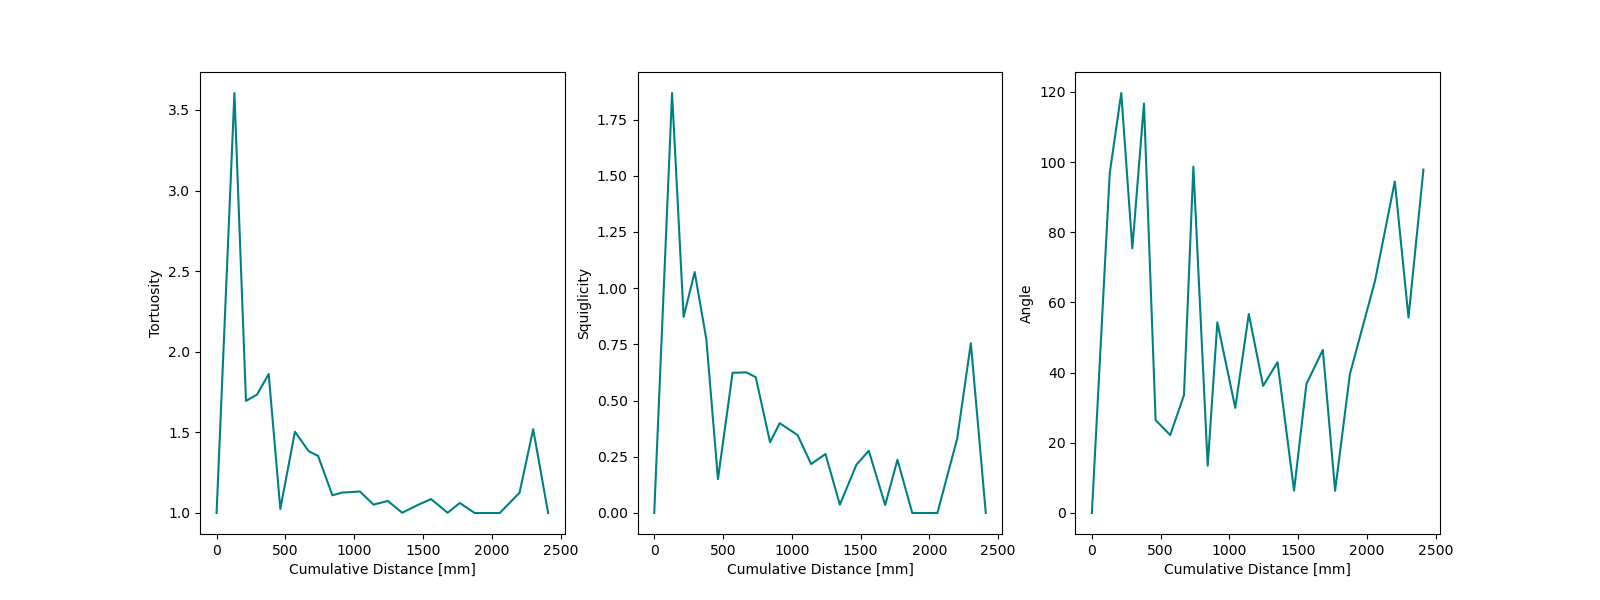

In [56]:

fig, axs = plt.subplots(1, 3, figsize=(16, 6))

axs[0].plot(df[df.primary == 1].cumulative_distance, df[df.primary == 1]["Tortuosity"], c="Teal")
axs[0].set_xlabel("Cumulative Distance [mm]")
axs[0].set_ylabel("Tortuosity")

axs[1].plot(df[df.primary == 1].cumulative_distance, df[df.primary == 1]["Squiglicity"], c="Teal")
axs[1].set_xlabel("Cumulative Distance [mm]")
axs[1].set_ylabel("Squiglicity")


axs[2].plot(df[df.primary == 1].cumulative_distance, df[df.primary == 1]["angle"], c="Teal")
axs[2].set_xlabel("Cumulative Distance [mm]")
axs[2].set_ylabel("Angle")